# Executive Summary

This document provides an analysis on Chicago bike sharing data (https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data) to understand the effect of temperature on bike trip counts and durations, controlling for any relevant seasonality and customer segments.

Data exploration is first conducted to identify the important variables with significant interactions. Features analyzed include temporal features, user features, spatial features and weather features.

Two models are trained on top of the important features identified - trip duration model and trip counts model. 
 - Trip duration model is on trip level. It is a linear regresion model with trip duration as the dependent variable.
 - Trip counts model is a count model on a hourly basis. The model is a negative binomial model, as the variance of the trip counts far exceeded the mean, leading to overdispersion. 
 - The control variables used in both models are as below so that the `temperature` effect excludes any seasonal or other confounding patterns:
     - temporal features: `Year`, `Month`, `Day`, `Weekday/Weekend`, `Holiday or not`, `Hour`
     - spatial feature: `Straightline Distance` generated from start and end stations
     - user features: `Gender (Female/Male)` and `User Type (Subscriber or not)`
 
 - `Temperature` feature is discretized into a few categories based on the percentiles so that the pattern and impacts of different temperature range are better captured.

Model results show that there is a general increasing trend between temperature and trip duration/counts. Higher temperature boosts trip counts as well as the duration of those trips. And this impact is nonlinear - as temperature increases, the incremental change in trip duration/counts within each temperature range increases as well. 

However there is a difference in this pattern of the incremental change between trip duration and trip counts models.
 - For trip duration, the incremental change which is brought by the temperature increase, initially speeds up till around 70 degrees (60th percentile) and then slows down. 
 - For trip counts, the incremental change slows down as temperature goes up. In fact, the temperature effect peaks around 80 degrees (90th percentile).

Detailed analysis is provided below.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

pd.set_option('display.max_columns', None)

# Data Exploration

100k data are randomly selected from the original dataset and used in this analysis. <br />
Some basic housekeepings are conducted to ensure the dataset is ready for the analysis, such as converting `starttime` into `timestamp`, checking the existence of `null` values, and `outliers` (by multiple scatterplots).

In [2]:
data = pd.read_csv('data.csv')
data = data.sample(100000, random_state = 123)
data.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
5661468,10987196,2016,7,30,3,19,Subscriber,Male,2016-07-28 19:23:47,2016-07-28 19:32:17,8.516667,73.0,cloudy,344,Ravenswood Ave & Lawrence Ave,41.969090,-87.674237,39.0,231,Sheridan Rd & Montrose Ave,41.961670,-87.654640,15.0
3863073,9039738,2016,3,12,6,15,Subscriber,Male,2016-03-27 15:30:00,2016-03-27 15:39:00,9.316667,51.1,rain or snow,199,Wabash Ave & Grand Ave,41.891738,-87.626937,15.0,26,McClurg Ct & Illinois St,41.891020,-87.617300,31.0
3833804,7748061,2015,10,40,3,8,Subscriber,Male,2015-10-01 08:35:00,2015-10-01 08:45:00,9.966667,55.9,cloudy,156,Clark St & Wellington Ave,41.936497,-87.647539,15.0,230,Lincoln Ave & Roscoe St,41.943340,-87.670970,19.0
7709713,13597740,2017,4,14,6,19,Subscriber,Male,2017-04-09 19:25:59,2017-04-09 19:32:02,6.050000,73.0,cloudy,20,Sheffield Ave & Kingsbury St,41.910522,-87.653106,15.0,365,Halsted St & North Branch St,41.899368,-87.648480,15.0
8847004,14986879,2017,7,27,3,20,Subscriber,Male,2017-07-06 20:32:05,2017-07-06 20:44:04,11.983333,84.9,cloudy,99,Lake Shore Dr & Ohio St,41.892570,-87.614492,19.0,84,Milwaukee Ave & Grand Ave,41.891578,-87.648384,19.0


In [3]:
data['starttime'] = pd.to_datetime(data.starttime)
data['stoptime'] = pd.to_datetime(data.stoptime)

In [4]:
data.shape

(100000, 23)

In [5]:
data.isnull().sum().sum()

0

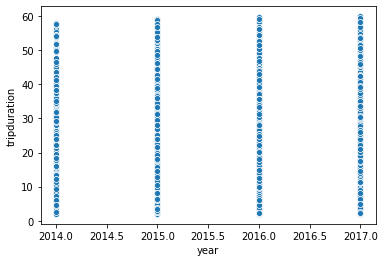

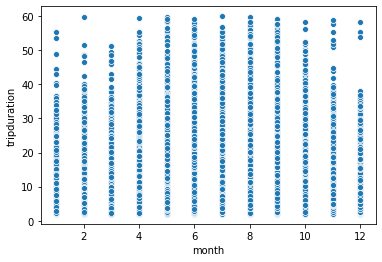

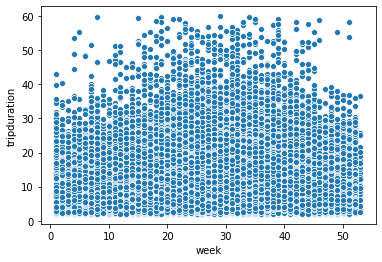

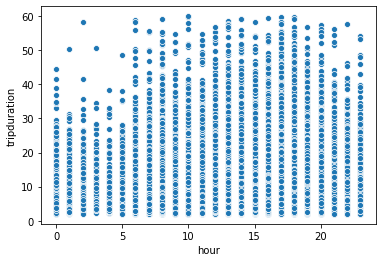

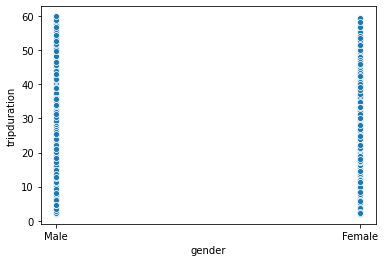

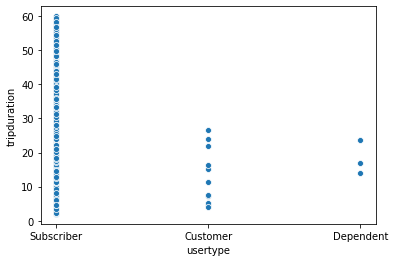

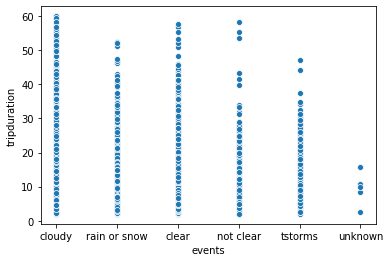

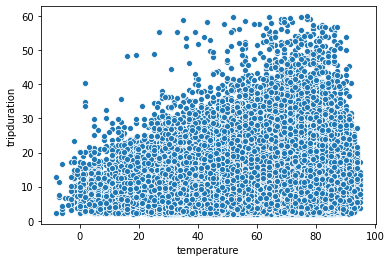

In [6]:
sns.scatterplot(x = 'year', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'month', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'week', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'hour', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'gender', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'usertype', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'events', y = 'tripduration',data = data)
plt.show()
sns.scatterplot(x = 'temperature', y = 'tripduration',data = data)
plt.show()

<br />
The distribution of trip duration is ploted as below - it is a right-skewed distribution with a min of 2 mins and a max of 60 mins.

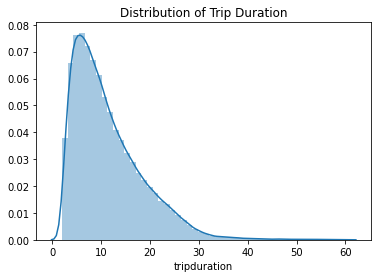

count    100000.000000
mean         11.389752
std           7.139867
min           2.000000
25%           6.016667
50%           9.616667
75%          15.133333
max          60.000000
Name: tripduration, dtype: float64


In [7]:
sns.distplot(data.tripduration)
plt.title('Distribution of Trip Duration')
plt.show()
print (data.tripduration.describe())

In [8]:
percentile = [i/10 for i in range(1, 10)]
temp_percentile = data.temperature.quantile(percentile)
print('Temperature Percentiles')
print(temp_percentile)

Temperature Percentiles
0.1    37.9
0.2    48.0
0.3    55.9
0.4    62.1
0.5    66.9
0.6    71.1
0.7    73.9
0.8    78.1
0.9    82.0
Name: temperature, dtype: float64


## I. Temporal Features

Trip counts and Trip duration by `Year` are ploted as below. <br />
It is shown that total number of trips per year keeps increasing from 2014 to 2017, while the distributions of trip duration are quite consistent throughout those years.

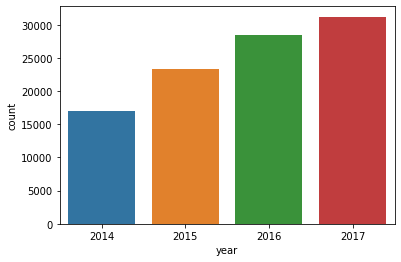

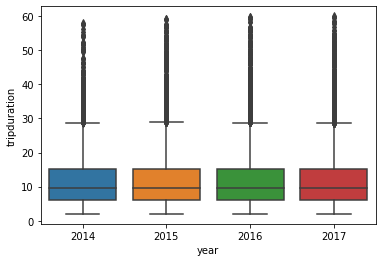

In [9]:
sns.countplot(x="year", data=data)
plt.show()
sns.boxplot(x='year', y = 'tripduration', data = data)
plt.show()

Trip counts and Trip duration by `Month` are ploted as below. <br />
It is shown that seasonal pattern exists in total number of trips - more trips during spring/fall, peak in summer, and least trips during winter time. Trip duration also follows similar seasonal pattern - longer trip durations in summer and shorter trip durations in winter.

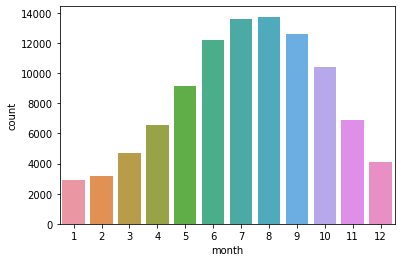

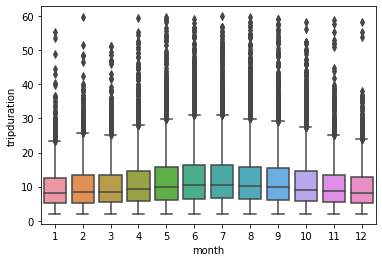

In [10]:
sns.countplot(x="month", data=data)
plt.show()
sns.boxplot(x='month', y = 'tripduration', data = data)
plt.show()

Trip counts and Trip duration by `Hour` are ploted as below. <br />
From trip counts perspective, there are two obvious peaks in a day - AM peak (7am-8am) and PM peak (4pm-6pm). The average hourly trip count is 4.  For trip duration, the distribution difference is slight throughout the day with an average of 11min trip duration.

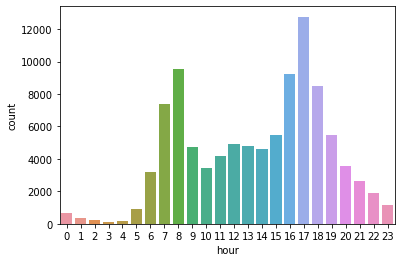

Average trip counts per hour: 4.0


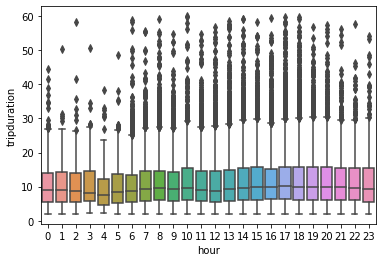

Average trip duration per hour: 11.0 min


In [11]:
sns.countplot(x="hour", data=data)
plt.show()
print ('Average trip counts per hour:', np.round(data.groupby([data.starttime.dt.date, data.hour])['trip_id'].count().mean()))
sns.boxplot(x='hour', y = 'tripduration', data = data)
plt.show()
print ('Average trip duration per hour:', np.round(data.groupby('hour')['tripduration'].mean().mean()), 'min')

Trip counts and Trip duration by `Day of Week` are ploted as below.<br />
Weekday and weekend patterns are quite different in both trip counts and trip duration. Weekday tends to have more trips but shorter trips, while weekend tends to have fewer but longer trips. An hypothesis for this is that people bike for different purposes on weekdays vs weekends.

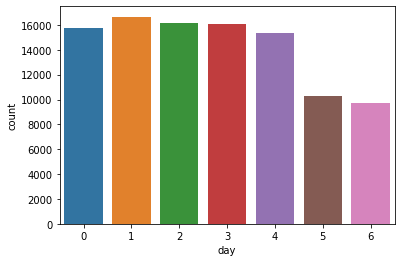

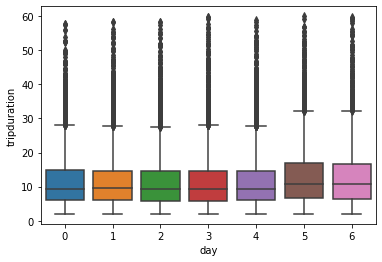

          mean       std
day                     
0    11.210329  6.926088
1    11.153425  6.904484
2    10.980564  6.818845
3    11.085204  6.960279
4    11.150538  6.999694
5    12.535481  7.952176
6    12.435253  7.759362


In [12]:
sns.countplot(x="day", data=data)
plt.show()
sns.boxplot(x='day', y = 'tripduration', data = data)
plt.show()
print(data.groupby('day')['tripduration'].agg(['mean', 'std']))

Trip counts and Trip duration by `Holiday` are ploted as below. `Holiday` variable is generate to identify whether it is a public holiday or not.<br />
Average trip counts in holidays are fewer than regular days, while there is no big difference in trip durations.

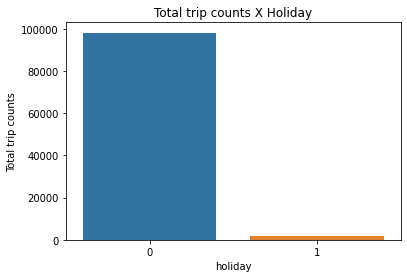

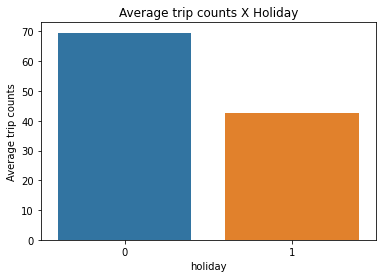

Average trip counts of non-holiday: 70
Average trip counts of holiday: 43


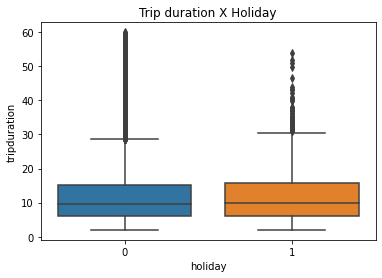

              mean       std
holiday                     
0        11.381340  7.129852
1        11.829251  7.634054


In [13]:
data['holiday'] = np.where(data.starttime.dt.date.isin(holidays.US(years=data.year)), 1, 0)
sns.countplot(x="holiday", data=data)
plt.ylabel("Total trip counts")
plt.title('Total trip counts X Holiday')
plt.show()

temp = data.groupby(['holiday', data.starttime.dt.date])['trip_id'].count().reset_index().groupby('holiday').mean().reset_index()
sns.barplot(x='holiday', y='trip_id', data = temp)
plt.ylabel("Average trip counts")
plt.title('Average trip counts X Holiday')
plt.show()

print('Average trip counts of non-holiday:', round(len(data[data.holiday == 0])/len(data[data.holiday == 0]['starttime'].dt.date.unique())))
print('Average trip counts of holiday:', round(len(data[data.holiday == 1])/len(data[data.holiday == 1]['starttime'].dt.date.unique())))

sns.boxplot(x='holiday', y = 'tripduration', data = data)
plt.title('Trip duration X Holiday')
plt.show()
print(data.groupby('holiday')['tripduration'].agg(['mean', 'std']))


## II. User Features

Trip counts and Trip duration by `User Type` are ploted as below.<br />
Subscribers contribute over 99.9% of the total trips and their daily average trip count is much higher than the other two types. The distributions among different user types vary as well.

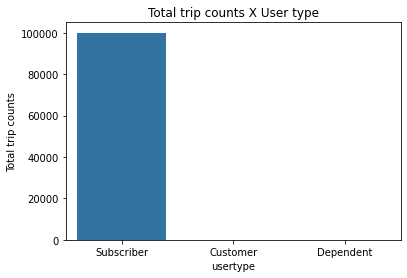

Percentage of Subscribers: 0.99986


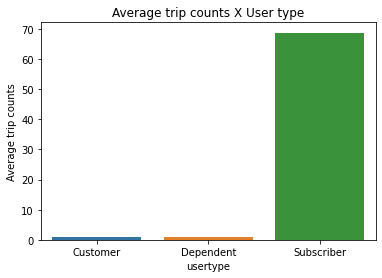

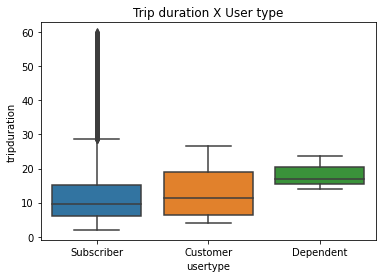

                 mean       std
usertype                       
Customer    13.139394  8.225537
Dependent   18.188889  5.085610
Subscriber  11.389356  7.139736


In [14]:
sns.countplot(x="usertype", data=data)
plt.ylabel("Total trip counts")
plt.title('Total trip counts X User type')
plt.show()
print('Percentage of Subscribers:', len(data[data.usertype == 'Subscriber'])/len(data))

temp = data.groupby(['usertype', data.starttime.dt.date])['trip_id'].count().reset_index().groupby('usertype').mean().reset_index()
sns.barplot(x='usertype', y='trip_id', data = temp)
plt.ylabel("Average trip counts")
plt.title('Average trip counts X User type')
plt.show()

sns.boxplot(x='usertype', y = 'tripduration', data = data)
plt.title('Trip duration X User type')
plt.show()
print(data.groupby('usertype')['tripduration'].agg(['mean', 'std']))

Trip counts and Trip duration by `Gender` are ploted as below.<br />
Male users contribute 75% of the total trips and their daily average trip count is higher, while females tend to bike longer time (~2 mins longer than males' trip on average).

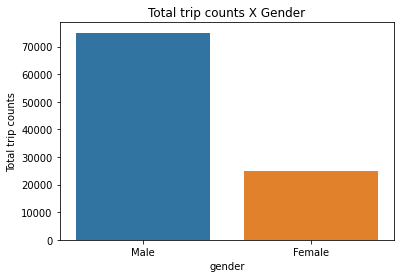

Percentage of Male users: 0.75051


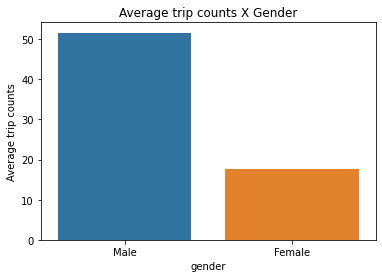

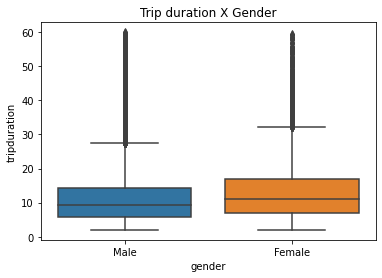

             mean       std
gender                     
Female  12.759664  7.617469
Male    10.934356  6.914059


In [15]:
sns.countplot(x="gender", data=data)
plt.ylabel("Total trip counts")
plt.title('Total trip counts X Gender')
plt.show()
print('Percentage of Male users:', len(data[data.gender == 'Male'])/len(data))

temp = data.groupby(['gender', data.starttime.dt.date])['trip_id'].count().reset_index().groupby('gender').mean().reset_index().sort_values(by = 'gender', ascending = False)
sns.barplot(x='gender', y='trip_id', data = temp)
plt.ylabel("Average trip counts")
plt.title('Average trip counts X Gender')
plt.show()

sns.boxplot(x='gender', y = 'tripduration', data = data)
plt.title('Trip duration X Gender')
plt.show()
print(data.groupby('gender')['tripduration'].agg(['mean', 'std']))

## III. Weather Features

Trip counts and Trip duration by `Weather Event` are ploted as below.<br />
88% of the total trips occurs in cloudy weather. Trip duration varies a bit in different weather conditions as well.

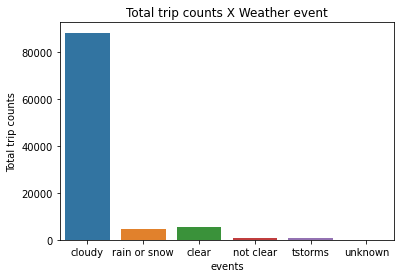

Percentage of Cloudy: 0.88404


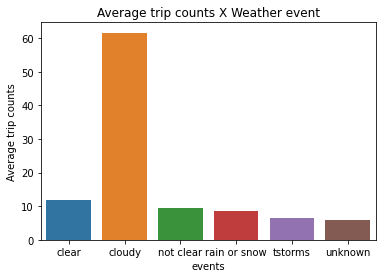

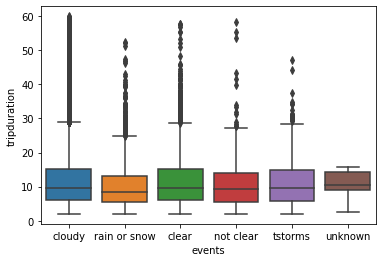

In [16]:
sns.countplot(x="events", data=data)
plt.ylabel("Total trip counts")
plt.title('Total trip counts X Weather event')
plt.show()
print('Percentage of Cloudy:', len(data[data.events == 'cloudy'])/len(data))

temp = data.groupby(['events', data.starttime.dt.date])['trip_id'].count().reset_index().groupby('events').mean().reset_index()
sns.barplot(x='events', y='trip_id', data = temp)
plt.ylabel("Average trip counts")
plt.title('Average trip counts X Weather event')
plt.show()

sns.boxplot(x='events', y = 'tripduration', data = data)
plt.show()

The distribution plot of `Temperature` indicates that most trips occur in the 70 - 80 temperature range.

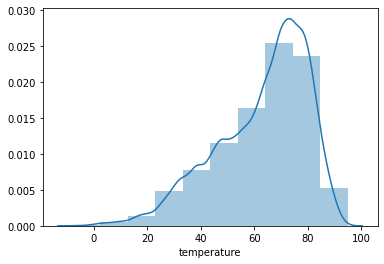

In [17]:
sns.distplot(data.temperature, bins=10)
plt.show()

A scatterplot of Trip duration _X_ `Temperature` is presented as below. <br />
An increasing trend in trip duration is observed as temperature increases.

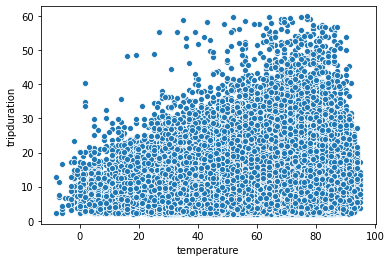

In [18]:
sns.scatterplot(x="temperature", y = 'tripduration', data=data)
plt.show()
# data.plot.hexbin(x="temperature", y = 'tripduration', gridsize = 15)
# plt.show()

## IV. Spatial Features

`Straightline distance` between start station and end station of a single trip is estimated.<br />
A close relationship is observed between trip duration and `straightline distance`.

In [19]:
from vincenty import vincenty
data['distance'] = [vincenty((data.latitude_start.iloc[k], data.longitude_start.iloc[k]), 
                            (data.latitude_end.iloc[k], data.longitude_end.iloc[k]),
                           miles = True) for k in range(0,len(data))]

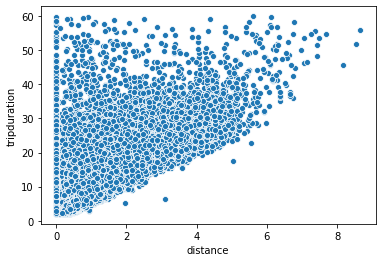

In [20]:
sns.scatterplot(x="distance", y = 'tripduration', data=data)
plt.show()

## V. Correlations

A correlation plot among all features is presented before modeling analysis.

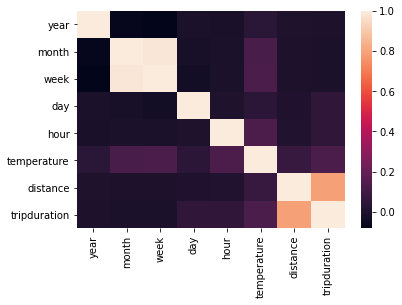

In [21]:
corr = data[['year', 'month', 'week', 'day', 'hour', 'gender', 'usertype', 'events', 'temperature', 'distance', 'tripduration']].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns) 

# Modeling

Models for Trip duration and Trip counts are trained seperately, with the entire dataset. The features used in the model include:
 - temporal features in different time scales
 - user related features (demographic, segmentation)
 - spatial features

## I. Trip Duration

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [23]:
data['dow'] = np.where(data.day < 5, 1, 0)
data['type'] = np.where(data.usertype == 'Subscriber', 1, 0)

In [24]:
def sum_multiply(a,b):
    return sum(x * y for x, y in zip(a, b))

As shown in the data exploration section, there is a positive correlation between `temperature` and trip duration. In order to clearly identify this impact, the temperature feature is categorized into 10 groups according to the percentile. For example,
 - temperature between 0th and 10th percentile is tagged as group 1
 - temperature between 10th and 20th percentile is tagged as group 2
 - ...

In [25]:
def get_quantile(temp):
    if temp <= temp_percentile[0.1]:
        return 1
    elif temp <= temp_percentile[0.2]:
        return 2
    elif temp <= temp_percentile[0.3]:
        return 3
    elif temp <= temp_percentile[0.4]:
        return 4
    elif temp <= temp_percentile[0.5]:
        return 5
    elif temp <= temp_percentile[0.6]:
        return 6
    elif temp <= temp_percentile[0.7]:
        return 7
    elif temp <= temp_percentile[0.8]:
        return 8
    elif temp <= temp_percentile[0.9]:
        return 9
    else:
        return 10
data['temp_cat'] = data['temperature'].apply(get_quantile)

A linear regression model is trained with categorical feaures: `year`, `month`, `hour`, `day`, `holiday`, `gender`, `usertype`, `events` and `temp_cat`(temperature category), and continuous feature: `straightline distance`. <br />
The model results are shown in the table belown with R-squared of 0.641.

In [26]:
formula = 'tripduration ~ C(year) + C(month) + C(hour) + C(gender) + C(type) + C(events) + \
            C(dow) + C(holiday) + distance + C(temp_cat)'
trip_length_mod = smf.ols(formula=formula, data=data).fit()
trip_length_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tripduration   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     3186.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:07:33   Log-Likelihood:            -2.8725e+05
No. Observations:              100000   AIC:                         5.746e+05
Df Residuals:                   99943   BIC:                         5.752e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.2435      1.162      5.374      0.000       3.966       8.521
C(year)[T.2015]              -0.0329      0.043     -0.758      0.448      -0.118       0.052
C(year)[T.2016]              -0.0314      0.042     -0.746      0.456      -0.114       0.051
C(year)[T.2017]              -0.0595      0.041     -1.443      0.149      -0.140       0.021
C(month)[T.2]                 0.0251      0.111      0.225      0.822      -0.193       0.243
C(month)[T.3]                -0.0151      0.107     -0.141      0.888      -0.224       0.194
C(month)[T.4]                 0.0630      0.109      0.577      0.564      -0.151       0.277
C(month)[T.5]                 0.0628      0.111      0.566      0.571      -0.155       0.280
C(month)[T.6]                 0.0709      0.115      0.619      0.536      -0.154       0.295
C(month)[T.7]                -0.0303      0.115     -0.262      0.793      -0.257       0.196
C(month)[T.8]                -0.1325      0.115     -1.151      0.250      -0.358       0.093
C(month)[T.9]                -0.1737      0.112     -1.544      0.123      -0.394       0.047
C(month)[T.10]               -0.1136      0.107     -1.061      0.289      -0.324       0.096
C(month)[T.11]               -0.0904      0.103     -0.879      0.379      -0.292       0.111
C(month)[T.12]                0.0116      0.105      0.110      0.912      -0.194       0.217
C(hour)[T.1]                 -0.4660      0.276     -1.690      0.091      -1.006       0.074
C(hour)[T.2]                 -0.1563      0.321     -0.487      0.626      -0.786       0.473
C(hour)[T.3]                 -0.3394      0.406     -0.836      0.403      -1.136       0.457
C(hour)[T.4]                 -0.8032      0.366     -2.197      0.028      -1.520      -0.087
C(hour)[T.5]                 -1.0387      0.221     -4.707      0.000      -1.471      -0.606
C(hour)[T.6]                 -0.7431      0.185     -4.006      0.000      -1.107      -0.380
C(hour)[T.7]                 -0.2677      0.177     -1.516      0.130      -0.614       0.078
C(hour)[T.8]                  0.1396      0.175      0.798      0.425      -0.203       0.483
C(hour)[T.9]                  0.1203      0.180      0.668      0.504      -0.233       0.473
C(hour)[T.10]                 0.3804      0.184      2.066      0.039       0.020       0.741
C(hour)[T.11]                 0.5220      0.182      2.870      0.004       0.166       0.878
C(hour)[T.12]                 0.6082      0.180      3.373      0.001       0.255       0.962
C(hour)[T.13]                 0.8134      0.181      4.502      0.000       0.459       1.168
C(hour)[T.14]                 0.8577      0.181      4.734      0.000       0.503       1.213
C(hour)[T.15]                 0.7653      0.179      4.267      0.000      

A plot of the coefficients of the temperature category(`temp_cat`) is presented to show the pattern of temperature impact on trip duration. A few observations:<br>
 - **A general increasing trend exists** - higher temperature leads to longer trip duration, e.g., 
     - when temperature is between 62 and 67 (40th to 50th percentile), it adds **0.3363** min to trip duration compared to when the temperature is below 38 (0 to 10th percentile). 
     - when temperature is between 67 and 71 (50th to 60th percentile), it adds **0.6408** min to trip duration compared to when the temperature is below 38 (0 to 10th percentile). 
 - This impact is nonlinear - **the incremental change initially speeds up till around 70 degrees and then slows down**.
     


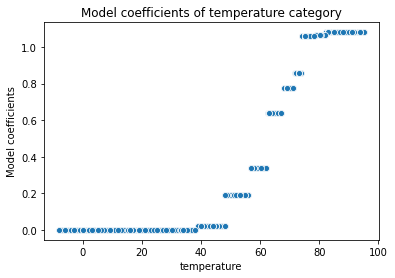

In [27]:
pred = np.select([data.temp_cat == 2, data.temp_cat == 3, data.temp_cat == 4, data.temp_cat == 5,
                 data.temp_cat == 6, data.temp_cat == 7, data.temp_cat == 8, data.temp_cat == 9, data.temp_cat == 10],
                [trip_length_mod.params[-10], trip_length_mod.params[-9], trip_length_mod.params[-8], trip_length_mod.params[-7], trip_length_mod.params[-6],
                 trip_length_mod.params[-5], trip_length_mod.params[-4], trip_length_mod.params[-3], trip_length_mod.params[-2]],
                default = 0)
sns.scatterplot(x = data.temperature, y = pred)
plt.ylabel('Model coefficients')
plt.title('Model coefficients of temperature category')
plt.show()


## II. Trip Counts

For trip count modeling, a trip aggragation is first conducted. Trip data is aggregated by hour of each single day (from 2014-01-01 to 2017-12-31). Thus this modeling is based on hourly trip counts.

In [28]:
from datetime import date, timedelta

sdate = data.starttime.min().date()
edate = data.starttime.max().date()
delta = edate - sdate       # as timedelta

full_list = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    full_list.append(day)

In [29]:
data['date'] = data.starttime.dt.date
data_counts = data.groupby(['date', 'hour']).agg(
    counts = ('temperature', 'count'), temperature = ('temperature', 'mean'), events = ('events', list)).reset_index()
data_counts['events'] = data_counts['events'].apply(lambda x: list(set(x))).str.join(',')

In [30]:
full_list = pd.DataFrame({'date': full_list})
import itertools
full_list = list(itertools.product(full_list.date, range(0,24)))


In [31]:
mind = pd.MultiIndex.from_tuples(
    full_list, names=['date', 'hour'])
data_counts = data_counts.set_index(['date', 'hour']).reindex(mind, fill_value=0).reset_index()
data_counts.sort_values(by = ['date', 'hour'], inplace=True)
data_counts['year'] = data_counts.date.dt.year
data_counts['month'] = data_counts.date.dt.month
data_counts['day'] = data_counts.date.dt.day
data_counts['date'] = data_counts.date.dt.date

In [32]:
data_counts['holiday'] = np.where(data_counts.date.isin(holidays.US(years=data_counts.year)), 1, 0)
data_counts['dow'] = np.where(data_counts.day < 5, 1, 0)

In [33]:
len(data_counts[data_counts['counts']==0])

12295

### Filling missing data
12295 data entries are missing in the dataset. To fill the missing data, a few assumptions are made:
 - temperature: the temperature information from the raw database (https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data?select=data_raw.csv) is used by following two steps.
     - if there is temperature information on the same date in the raw database, then that temperature is mapped into the trip counts table.
     - if temperature information for that date does not exist in the raw database as well, then an average temperature of the same month and day across multiple years is estimated and mapped into the trip counts table.
 - events: the weather event information is consistent throughout the day. Thus the missing data is filled by the weather event information in the other hours of that day.

In [34]:
data_raw = pd.read_csv('data_raw.csv')
data_raw['date'] = pd.to_datetime(data_raw.starttime).dt.date
data_raw['month'] = pd.to_datetime(data_raw.starttime).dt.month
data_raw['day'] = pd.to_datetime(data_raw.starttime).dt.day
data_raw['hour'] = pd.to_datetime(data_raw.starttime).dt.hour
temp_mapping = data_raw.groupby(['date', 'hour']).temperature.mean().reset_index()
temp_mapping_2 = data_raw.groupby(['month', 'day', 'hour']).temperature.mean().reset_index()

In [35]:
data_counts = data_counts.merge(temp_mapping, on = ['date', 'hour'], suffixes = ['', '_avg'], how = 'left')
data_counts = data_counts.merge(temp_mapping_2, on = ['month', 'day', 'hour'],
                 suffixes = ['', '_avg_2'], how = 'left')
data_counts['temperature'] = np.where(data_counts.counts == 0,
                                      np.where(data_counts.temperature_avg.notnull(), data_counts.temperature_avg, data_counts.temperature_avg_2),
                                      data_counts.temperature)
data_counts.drop(['temperature_avg', 'temperature_avg_2'], axis=1, inplace = True)
data_counts['temperature'] = np.where(data_counts.temperature<-100, 0, data_counts.temperature)

In [36]:
def fill_gap(df):
    for index, row in df.iterrows():
        if row.counts == 0:
            for n in range(0,1000):
                if index+n<=df.index.max():
                    if df.at[index+n, 'counts'] > 0:
                        df.at[index, 'events'] = df.at[index+n, 'events']
                        break
                else:
                    if df.at[index-n, 'counts'] > 0:
                        df.at[index, 'events'] = df.at[index-n, 'events']
                        break
    return df
data_counts = fill_gap(data_counts)

A Negative binomial regression is fitted with categorical feaures: `year`, `month`, `hour`, `day`, `holiday`, `events` and `temp_cat` (temperature category). <br /> <br />
_Note that the user-related features (eg., `gender`, `usertype`) and trip-specific features (eg., `distance`) are not included as the aggregation of these features does not make sense to this hourly trip counts model._ <br /><br />
The model results are shown in the table below. 

In [37]:
data_counts['temp_cat'] = data_counts['temperature'].apply(get_quantile)

In [38]:
formula = 'counts ~ C(year) + C(month) + C(hour) + C(holiday) + C(dow) + C(events) + C(temp_cat) '
trip_counts_mod = smf.glm(formula=formula, data=data_counts, family=sm.families.NegativeBinomial()).fit()
trip_counts_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 counts   No. Observations:                35064
Model:                            GLM   Df Residuals:                    35010
Model Family:        NegativeBinomial   Df Model:                           53
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62583.
Date:                Thu, 09 Jul 2020   Deviance:                       20011.
Time:                        11:09:33   Pearson chi2:                 1.92e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.1521      0.064    -33.511      0.000      -2.278      -2.026
C(year)[T.2015]               0.2866      0.021     13.754      0.000       0.246       0.327
C(year)[T.2016]               0.5089      0.021     24.675      0.000       0.468       0.549
C(year)[T.2017]               0.5936      0.021     28.946      0.000       0.553       0.634
C(month)[T.2]                 0.0155      0.042      0.368      0.713      -0.067       0.098
C(month)[T.3]                 0.1820      0.041      4.405      0.000       0.101       0.263
C(month)[T.4]                 0.3146      0.044      7.071      0.000       0.227       0.402
C(month)[T.5]                 0.4843      0.047     10.338      0.000       0.392       0.576
C(month)[T.6]                 0.6806      0.051     13.418      0.000       0.581       0.780
C(month)[T.7]                 0.7800      0.051     15.149      0.000       0.679       0.881
C(month)[T.8]                 0.7384      0.052     14.331      0.000       0.637       0.839
C(month)[T.9]                 0.7290      0.049     14.733      0.000       0.632       0.826
C(month)[T.10]                0.6937      0.045     15.344      0.000       0.605       0.782
C(month)[T.11]                0.5751      0.041     13.940      0.000       0.494       0.656
C(month)[T.12]                0.2768      0.040      6.930      0.000       0.199       0.355
C(hour)[T.1]                 -0.4939      0.077     -6.439      0.000      -0.644      -0.344
C(hour)[T.2]                 -0.9397      0.086    -10.934      0.000      -1.108      -0.771
C(hour)[T.3]                 -1.5374      0.104    -14.783      0.000      -1.741      -1.334
C(hour)[T.4]                 -1.2480      0.095    -13.155      0.000      -1.434      -1.062
C(hour)[T.5]                  0.4073      0.066      6.170      0.000       0.278       0.537
C(hour)[T.6]                  1.6741      0.059     28.257      0.000       1.558       1.790
C(hour)[T.7]                  2.4747      0.057     43.043      0.000       2.362       2.587
C(hour)[T.8]                  2.7374      0.057     47.884      0.000       2.625       2.849
C(hour)[T.9]                  1.9845      0.058     34.005      0.000       1.870       2.099
C(hour)[T.10]                 1.6184      0.059     27.274      0.000       1.502       1.735
C(hour)[T.11]                 1.7932      0.059     30.405      0.000       1.678       1.909
C(hour)[T.12]                 1.9311      0.059     32.867      0.000       1.816       2.046
C(hour)[T.13]                 1.9045      0.059     32.346      0.000       1.789       2.020
C(hour)[T.14]                 1.8783      0.059     31.834      0.000       1.763       1.994
C(hour)[T.15]                 2.0661      0.059     35.256      0.000      

A plot of the coefficients of temperature category (`temp_cat`) is presented to show the pattern of temperature impact on trip counts. Some interesting observations: <br>
- **A general increasing trend exists** - higher temperature boosts trip counts, e.g.,
    - when temperature is between 62 and 67 (40th to 50th percentile), it adds **0.6903** more trips compared to when the temperature is below 38 (0 to 10th percentile).
    - when temperature is between 67 and 71 (50th to 60th percentile), it adds **0.8224** more trips compared to when the temperature is below 38 (0 to 10th percentile).
- This impact is nonlinear - **higher temprature motivates more bike trips, but the incremental change slows down**. In fact, the coefficient peaks at the 90th temperature category (around 80 degrees). 


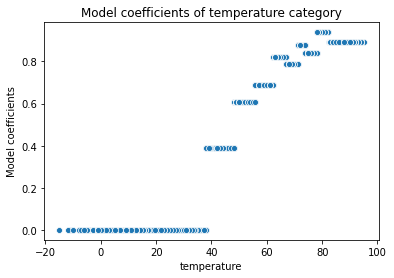

In [39]:
pred = np.select([data_counts.temp_cat == 2, data_counts.temp_cat == 3, data_counts.temp_cat == 4, data_counts.temp_cat == 5,
                 data_counts.temp_cat == 6, data_counts.temp_cat == 7, data_counts.temp_cat == 8, data_counts.temp_cat == 9, data_counts.temp_cat == 10],
                [trip_counts_mod.params[-9], trip_counts_mod.params[-8], trip_counts_mod.params[-7], trip_counts_mod.params[-6],
                 trip_counts_mod.params[-5], trip_counts_mod.params[-4], trip_counts_mod.params[-3], trip_counts_mod.params[-2], trip_counts_mod.params[-1]],
                default = 0)
plt.ylabel('Model coefficients')
plt.title('Model coefficients of temperature category')
sns.scatterplot(x = data_counts.temperature, y = pred)